In [1]:
from gal4H0 import *
from scipy.stats import gaussian_kde
np.random.seed(0) # Random seed
true_cosmology = FlatLambdaCDM(H0=70.,Om0=0.25) # True cosmology

## H_0 with 200 GW signals


In [11]:
galaxies_list = np.genfromtxt('MICECAT_LOS/micecat_455.csv',skip_header=1) # LOS with few galaxies
galaxies_list.max()

1.41706

In [8]:
Ngw=200
sigma_dl=0.3
zcut_rate=1.0
dl_thr=1550

# We draw GW events from galaxies between 0<z<1.0.
gw_obs_dl,_,_,std_dl=draw_gw_events(200,sigma_dl,dl_thr,galaxies_list,true_cosmology,zcut_rate)

# We draw GW events from galaxies between 0<z<0.3.
gw_obs_dl_wrong,_,_,_=draw_gw_events(200,sigma_dl,dl_thr,galaxies_list,true_cosmology,0.3)

# We build the interpolant for p_CBC(z) accounting for a rate cut at z=1.0 
sigmaz=0.013*np.power(1+galaxies_list,3.)
sigmaz[sigmaz>0.015]=0.015
z_obs=np.random.randn(len(galaxies_list))*sigmaz+galaxies_list
zinterpo,zinterpolant=build_interpolant(z_obs,sigmaz,zcut_rate,nocom='dvcdz')

You detected 200 binaries out of 100000 simulated
You detected 200 binaries out of 100000 simulated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2125/2125 [00:10<00:00, 211.32it/s]


In [9]:
H0_array=np.linspace(20,140,200)

# Correctly calculate the posterior. Here z_max=1.0 is not important since it is lower than the
# cut in d_L for detection anyway.
posterior_matrix, combined=galaxy_catalog_analysis_photo_redshift(H0_array,zinterpo,gw_obs_dl,sigma_dl,dl_thr)

# Wrong evaluation of H0 posterior. We generated GW events from z_max=0.3 which is close to the value of d_L
# for which the selection cut happens
posterior_matrix_wrong, combined_wrong=galaxy_catalog_analysis_photo_redshift(H0_array,zinterpo,gw_obs_dl_wrong,sigma_dl,dl_thr)

200it [00:00, 700.74it/s]
Running on GW events: 200it [01:59,  1.68it/s]
200it [00:00, 697.41it/s]
Running on GW events: 200it [01:55,  1.72it/s]


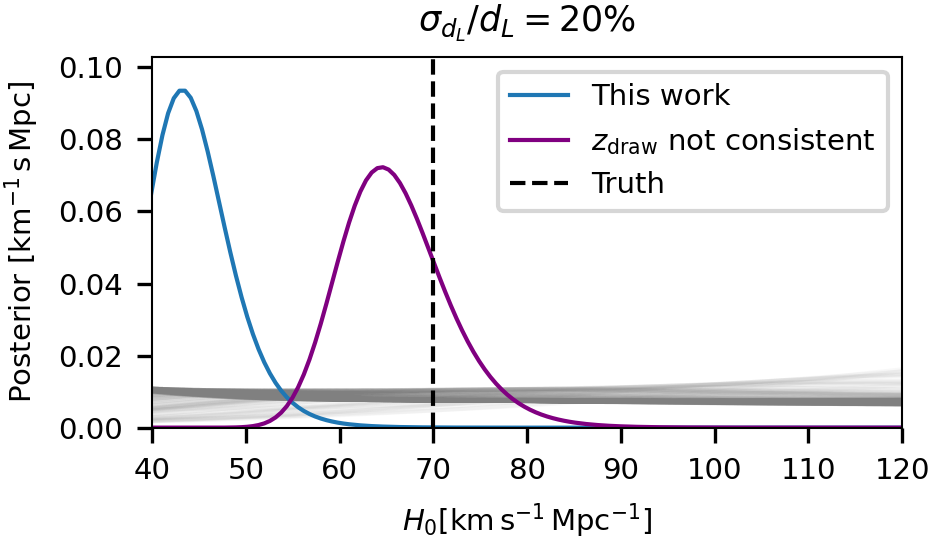

In [5]:
plt.figure(figsize=(3.3,2.0))
for i in range(200):
    plt.plot(H0_array,posterior_matrix[i,:],alpha=0.05,color='gray')

plt.plot(H0_array,combined,label='This work')
plt.plot(H0_array,combined_wrong,label=r'$z_{\rm draw}$ not consistent',color='purple')
    
plt.axvline(70.,ls='--',color='k',label='Truth')

plt.title(r'$\sigma_{d_L}/d_L=20\%$')
plt.ylim([0,combined.max()*1.1])
plt.xlim([40,120])
plt.xlabel(r'$H_0 {\rm[km \,s^{-1} \,Mpc^{-1}]}$')
plt.ylabel(r'Posterior ${\rm[km^{-1} \,s \,Mpc]}$')
plt.tight_layout()
plt.legend()

plt.savefig('figures_paper/H0_LOS1_200events.pdf')

In [6]:
np.random.seed(0) # Reset the number seed

In [7]:
# We generate multiple H0 posterior for 200 events, different LOS and dl errors

LOSf=['MICECAT_LOS/micecat_451.csv','MICECAT_LOS/micecat_455.csv',
     'MICECAT_LOS/micecat_901.csv','MICECAT_LOS/micecat_905.csv']

sigmas=[0.1,0.2,0.3]
Ngw=200
zcut_rate=1.0
dl_thr=1550
H0_array=np.linspace(40,120,100)

posteriors={'H0_grid':H0_array}

for ilos in LOSf:
    galaxies_list = np.genfromtxt(ilos,skip_header=1)

    sigmaz=0.013*np.power(1+galaxies_list,3.)
    sigmaz[sigmaz>0.015]=0.015
    z_obs=np.random.randn(len(galaxies_list))*sigmaz+galaxies_list
    zinterpo,zinterpolant=build_interpolant(z_obs,sigmaz,zcut_rate)
    
    for sigma in sigmas:
        print(sigma)
        sigma_dl=sigma
        gw_obs_dl,_,_,std_dl=draw_gw_events(Ngw,sigma_dl,dl_thr,galaxies_list,true_cosmology,zcut_rate)
        posterior_matrix,combined=galaxy_catalog_analysis_photo_redshift(H0_array,zinterpo,gw_obs_dl,sigma_dl,dl_thr)
        
        posteriors[ilos+'_'+str(sigma)+'_'+'signle']=posterior_matrix
        posteriors[ilos+'_'+str(sigma)+'_'+'combined']=combined


ValueError: `dataset` input should have multiple elements.

In [ ]:
fig, ax= plt.subplots(3,1,figsize=(3.5,4.5),sharex=True)
colors=[pal[0],pal[1],pal[2],pal[3]]
lines=['solid','--',':']

labels_1=[r'$D_{11}$',
        r'$D_{15}$',
        r'$D_{21}$',
        r'$D_{25}$']

labels_2=[r'$\sigma_{d_L}/d_L=10\%$',
         r'$\sigma_{d_L}/d_L=20\%$',
         r'$\sigma_{d_L}/d_L=30\%$']

n
for i in range(len(colors)):
    for j in range(len(lines)):
        ilos=LOSf[i]
        sigma=sigmas[j]
        if sigma!=0.1:
            continue
        ax[j].plot(H0_array,posteriors[ilos+'_'+str(sigma)+'_'+'combined'],ls='solid',color=colors[i],label=labels_1[i])

for j in range(3):
    ax[j].axvline(70.,ls='--',color='k',label='Truth')
    ax[j].set_xlim([40,120])    
    ax[j].yaxis.set_ticklabels([])
    ax[j].set_ylabel(r'Posterior ${\rm[km^{-1} \,s \,Mpc]}$'+'\n'+'('+labels_2[j]+')',fontsize=6)

ax[0].legend(frameon=False,ncol=2)

ax[2].set_xlabel(r'$H_0 {\rm[km \,s^{-1} \,Mpc^{-1}]}$')
#plt.tight_layout()
plt.savefig('figures_paper/big_fig.pdf')

